In [ ]:
# Montage de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importation des bibliothèques
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from datetime import datetime

# Affichage de la version de TensorFlow et vérification de la disponibilité du GPU
print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU disponible: []


In [ ]:
# Définition des chemins d’accès aux fichiers

# Répertoire de base contenant les données sur Google Drive
BASE_DIR = "/content/drive/MyDrive"

# Chemin vers le fichier CSV 
csv_path = os.path.join(BASE_DIR, "bone_age_project/boneage-training-dataset.csv") 

# Chemin vers le dossier contenant les images radiographiques
images_folder = os.path.join(BASE_DIR, "bone_age_project/boneage-training-dataset") 

# Chemin de sauvegarde du modèle entraîné
models_dir = os.path.join(BASE_DIR, "models") 

# Chemin de sauvegarde des journaux d'entraînement (logs TensorBoard)
logs_dir = os.path.join(BASE_DIR, "logs") 

# Création des répertoires de sortie s’ils n’existent pas
os.makedirs(models_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
print("Configuration initiale terminée")

# Chargement du fichier CSV
df = pd.read_csv(csv_path)

# Affichage d’un aperçu des premières lignes du jeu de données
print("\nAperçu des données:")
print(df.head())

# Affichage du nombre total de données disponibles
print(f"Nombre total d'images: {len(df)}")

# Définition du chemin vers une image d’exemple afin de vérifier la validité du lien et le bon fonctionnement de la lecture d'image
sample_image_path = os.path.join(images_folder, str(df['id'].iloc[180]) + ".png")
print(f"\nChemin vers l'image d'exemple: {sample_image_path}")
print(f"L'image existe: {os.path.exists(sample_image_path)}")

Configuration initiale terminée

Aperçu des données:
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False
Nombre total d'images: 12611

Chemin vers l'image d'exemple: /content/drive/MyDrive/bone_age_project/boneage-training-dataset/1581.png
L'image existe: True


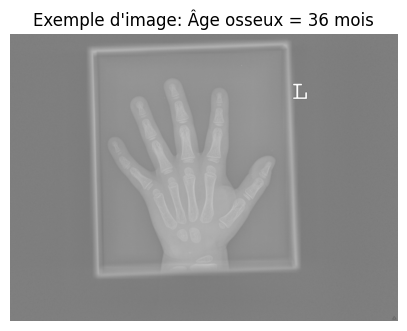


Répartition des données:
- Entraînement: 10088 images (10088)
- Validation: 1261 images (1261)
- Test: 1262 images (1262)


In [ ]:
# Affichage d'une image d’exemple extraite du jeu de données
# Cette étape permet de vérifier que le chemin vers l’image est correct et que le chargement se fait convenablement
if os.path.exists(sample_image_path):
    import cv2
    sample_img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE) # Chargement de l’image en niveaux de gris
    plt.figure(figsize=(5, 5))
    plt.imshow(sample_img, cmap='gray') # Affichage de l’image avec une échelle de gris
    plt.title(f"Exemple d'image: Âge osseux = {df['boneage'].iloc[180]} mois") # Annotation de l’âge osseux réel
    plt.axis('off') # Suppression des axes pour un affichage plus clair
    plt.show()
else:
    print("L'image d'exemple n'existe pas, vérifiez le chemin.") # Message d’erreur si l’image est introuvable

# Division du jeu de données en trois sous-ensembles : entraînement, validation et test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42) # Séparation initiale (80% entraînement)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42) # Répartition restante : 10% validation, 10% test

# Affichage de la répartition des données dans chaque sous-ensemble
print("\nRépartition des données:") 
print(f"- Entraînement: {len(train_df)} images ({len(train_df)})")
print(f"- Validation: {len(val_df)} images ({len(val_df)})")
print(f"- Test: {len(test_df)} images ({len(test_df)})")

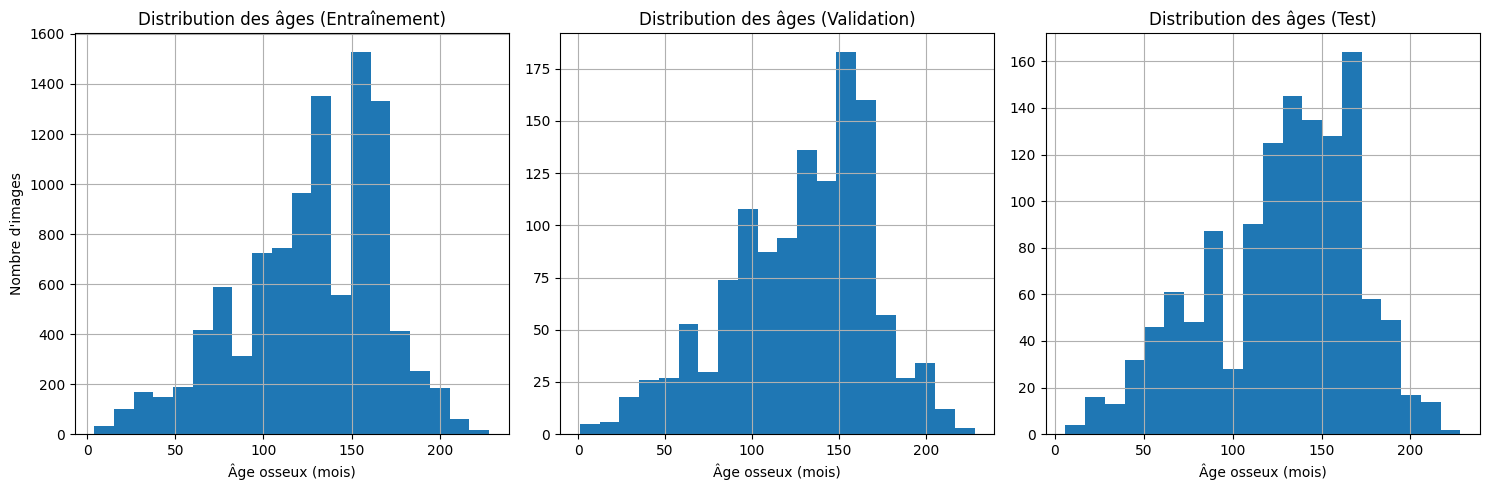

<Figure size 1000x400 with 0 Axes>

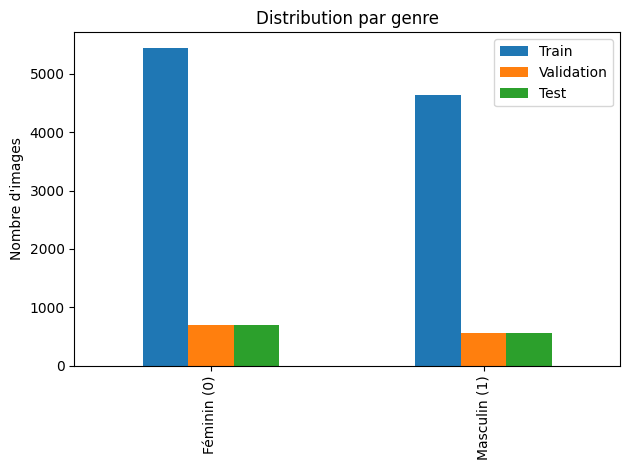

Préparation des données terminée


In [ ]:
# Visualisation de la distribution des âges osseux dans chaque sous-ensemble
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
train_df['boneage'].hist(bins=20)
plt.title('Distribution des âges (Entraînement)')
plt.xlabel('Âge osseux (mois)')
plt.ylabel('Nombre d\'images')

plt.subplot(1, 3, 2)
val_df['boneage'].hist(bins=20)
plt.title('Distribution des âges (Validation)')
plt.xlabel('Âge osseux (mois)')

plt.subplot(1, 3, 3)
test_df['boneage'].hist(bins=20)
plt.title('Distribution des âges (Test)')
plt.xlabel('Âge osseux (mois)')

plt.tight_layout()
plt.show()

# Analyse de la distribution par genre (masculin vs féminin) dans les trois sous-ensembles
plt.figure(figsize=(10, 4))

gender_counts = pd.concat([
    train_df['male'].value_counts().rename('Train'),
    val_df['male'].value_counts().rename('Validation'),
    test_df['male'].value_counts().rename('Test')
], axis=1)
gender_counts.index = ['Féminin (0)', 'Masculin (1)']
gender_counts.plot(kind='bar')

plt.title('Distribution par genre')
plt.ylabel('Nombre d\'images')
plt.tight_layout()
plt.show()

print("Préparation des données terminée")

In [ ]:
# Fonctions de prétraitement des images

# Normalisation de l'intensité des pixels (entre 0 et 1), normalisation avancée: ajuster le contraste 
def normalize_intensity(image):
    image = tf.cast(image, tf.float32) / 255.0 # Conversion en float et normalisation
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    image = (image - mean) / (std + 1e-5)  # Ajout d'un 1e-5 pour éviter la division par zéro
    return image

# Redimensionnement de l'image avec conservation du rapport d'aspect et ajout du remplissage (padding)
def resize_with_pad(image, target_height=224, target_width=224):
    image = tf.image.resize_with_pad(
        image, target_height, target_width,
        method=tf.image.ResizeMethod.BILINEAR
    )
    return image

# Fonction d'augmentation de données
def data_augmentation(image):
    image = tf.image.random_flip_left_right(image) # Miroir horizontal
    image = tf.image.random_brightness(image, 0.1) # Luminosité ±10%
    image = tf.image.random_contrast(image, 0.8, 1.2) # Contraste entre 80% et 120%
    angle = tf.random.uniform([], -10, 10) * (np.pi / 180) # Simulation d'une légère rotation aléatoire
    image = tf.image.rot90(image, k=tf.cast(angle * 2 / 3.14159, tf.int32)) 
    return image

# Pipeline complet de prétraitement pour une image donnée
def preprocess_image(image_path, augment=False):
    image_str = tf.io.read_file(image_path) 
    image = tf.image.decode_png(image_str, channels=1) 
    image = normalize_intensity(image)
    image = resize_with_pad(image)
    if augment:
        image = data_augmentation(image)
    return image

# Fonction de création d'un jeu de données structuré à partir d’un DataFrame
def create_dataset(dataframe, batch_size=32, augment=False, shuffle=True):
    # Génère un objet tf.data.Dataset à partir d’un DataFrame contenant :
    # Les identifiants d’images
    # L’âge osseux (normalisé entre 0 et 1)
    # Le genre (0 = fille, 1 = garçon)
    image_paths = [os.path.join(images_folder, str(id) + ".png") for id in dataframe['id']]
    
    ages = dataframe['boneage'].values / 228.0  
    
    genders = dataframe['male'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((
        image_paths,
        (ages, genders) 
    ))
    
    dataset = dataset.map(
        lambda x, y: (
            preprocess_image(x, augment=augment),
            y
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

print("Fonctions de prétraitement définies")

Fonctions de prétraitement définies


In [ ]:
# Création des jeux de données d'entraînement, de validation et de test

# Paramètre de taille de batch
batch_size = 32

# Le jeu d’entraînement inclut des transformations aléatoires (data augmentation)
train_dataset = create_dataset(train_df, batch_size=batch_size, augment=True, shuffle=True)

# Les jeux de validation et de test ne sont pas augmentés ni mélangés
val_dataset = create_dataset(val_df, batch_size=batch_size, augment=False, shuffle=False)
test_dataset = create_dataset(test_df, batch_size=batch_size, augment=False, shuffle=False)

print("Datasets créés avec succès")

Datasets créés avec succès


In [ ]:
# Construction d’un modèle de réseau de neurones convolutif (CNN) pour la prédiction de l’âge osseux

def create_cnn_model(input_shape=(224, 224, 1), regularization_rate=0.001):
    
    # Entrée pour l’image radiographique
    image_input = layers.Input(shape=input_shape, name='image_input')
    
    # Bloc de couches convolutives
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(regularization_rate))(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(regularization_rate))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(regularization_rate))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(regularization_rate))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Aplatir les caractéristiques et couches entièrement connectées
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(regularization_rate))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Entrée additionnelle pour le genre
    gender_input = layers.Input(shape=(1,), name='gender_input')
    gender_features = layers.Dense(64, activation='relu')(gender_input)

    # Fusion des deux sources d’information (image + genre)
    concat = layers.Concatenate()([x, gender_features])

    # Couches denses finales
    x = layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(regularization_rate))(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Couche de sortie : prédiction de l’âge osseux
    output = layers.Dense(1, activation='linear', name='age_output')(x)

    # Créer le modèle
    model = models.Model(inputs=[image_input, gender_input], outputs=output)

    # Compiler le modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',  # Mean Squared Error
        metrics=['mae']  # Mean Absolute Error
    )
    
    return model

# Fonction pour adapter le dataset au format d'entrée du modèle

# Cette fonction prend un tf.data.Dataset où chaque élément est un tuple (images, (âge, genre))
# et le transforme pour correspondre aux entrées nommées du modèle Keras.
def adapt_dataset_for_model(dataset):
    # Fonction interne qui prépare chaque élément du dataset.
    # Elle prend une image, un tuple (âge, genre), et le transforme en un dictionnaire.
    # la sortie attendue : l'âge osseux.
    def prepare_inputs(images, labels_tuple):
        ages = labels_tuple[0] # On extrait l'âge osseux (la sortie attendue du modèle)
        genders = labels_tuple[1] # On extrait le genre (utilisé comme deuxième entrée)
        genders = tf.expand_dims(genders, axis=-1) 
        return {'image_input': images, 'gender_input': genders}, ages
        # On applique la fonction de transformation à chaque élément du dataset.
        # avec .map(), ce qui adapte tout le dataset à la bonne structure.
    return dataset.map(prepare_inputs)

# Instanciation du modèle
model = create_cnn_model()

# Affichage de la structure du modèle
model.summary()

print("Modèle CNN défini avec succès")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 12,845,312 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,277,953 (50.65 MB)

 Trainable params: 13,276,225 (50.64 MB)

 Non-trainable params: 1,728 (6.75 KB)

Modèle CNN défini avec succès


In [ ]:
# Définition de la fonction d'entraînement du modèle
def train_model(model, train_dataset, val_dataset, epochs=30):
    
    # Adapter les ensembles de données au format d’entrée attendu par le modèle
    train_dataset_adapted = adapt_dataset_for_model(train_dataset)
    val_dataset_adapted = adapt_dataset_for_model(val_dataset)
    
    # Définition des callbacks
    callbacks = [
        
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(models_dir, 'best_model9.h5'),
            monitor='val_mae',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_mae',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        
        tf.keras.callbacks.EarlyStopping(
            monitor='val_mae',
            patience=5,
            restore_best_weights=True,
            verbose=1def create_dataset(dataframe, batch_size=32, augment=False, shuffle=True):

    image_paths = [os.path.join(images_folder, str(id) + ".png") for id in dataframe['id']]
    ages = dataframe['boneage'].values / 228.0  
    genders = dataframe['male'].values

    dataset = tf.data.Dataset.from_tensor_slices((
        image_paths,
        (ages, genders)  
    ))
        ),
        
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(logs_dir, datetime.now().strftime("%Y%m%d-%H%M%S")),
            histogram_freq=1
        )
    ]
    
    # Lancement de l'entraînement du modèle avec les données préparées
    history = model.fit(
        train_dataset_adapted,
        validation_data=val_dataset_adapted,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Entraînement du modèle
print("Début de l'entraînement du modèle...")

# Appel de la fonction d'entraînement
history = train_model(model, train_dataset, val_dataset, epochs=30)
print("Entraînement terminé")

# Sauvegarde du modèle final entraîné
model.save(os.path.join(models_dir, 'final_model9.h5'))
print(f"Modèle sauvegardé dans {os.path.join(models_dir, 'final_model9.h5')}")

Début de l'entraînement du modèle...
Epoch 1/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 2.8570 - mae: 0.8509 
Epoch 1: val_mae improved from inf to 0.18020, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 4164s 12s/step - loss: 2.8553 - mae: 0.8503 - val_loss: 1.5435 - val_mae: 0.1802 - learning_rate: 0.0010
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.6367 - mae: 0.3736
Epoch 2: val_mae improved from 0.18020 to 0.15155, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 1204s 4s/step - loss: 1.6362 - mae: 0.3734 - val_loss: 1.0835 - val_mae: 0.1515 - learning_rate: 0.0010
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.0430 - mae: 0.2303
Epoch 3: val_mae did not improve from 0.15155
316/316 ━━━━━━━━━━━━━━━━━━━━ 1171s 4s/step - loss: 1.0427 - mae: 0.2302 - val_loss: 0.7420 - val_mae: 0.1544 - learning_rate: 0.0010
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6982 - mae: 0.1779
Epoch 4: val_mae improved from 0.15155 to 0.14341, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 1212s 4s/step - loss: 0.6980 - mae: 0.1779 - val_loss: 0.5275 - val_mae: 0.1434 - learning_rate: 0.0010
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4947 - mae: 0.1520
Epoch 5: val_mae improved from 0.14341 to 0.14094, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 1192s 4s/step - loss: 0.4946 - mae: 0.1520 - val_loss: 0.3868 - val_mae: 0.1409 - learning_rate: 0.0010
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3645 - mae: 0.1361
Epoch 6: val_mae did not improve from 0.14094
316/316 ━━━━━━━━━━━━━━━━━━━━ 1193s 4s/step - loss: 0.3644 - mae: 0.1361 - val_loss: 0.2986 - val_mae: 0.1419 - learning_rate: 0.0010
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2754 - mae: 0.1247
Epoch 7: val_mae improved from 0.14094 to 0.12334, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 1116s 3s/step - loss: 0.2754 - mae: 0.1247 - val_loss: 0.2270 - val_mae: 0.1233 - learning_rate: 0.0010
Epoch 8/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2174 - mae: 0.1141
Epoch 8: val_mae did not improve from 0.12334
316/316 ━━━━━━━━━━━━━━━━━━━━ 1170s 3s/step - loss: 0.2173 - mae: 0.1141 - val_loss: 0.1942 - val_mae: 0.1420 - learning_rate: 0.0010
Epoch 9/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1753 - mae: 0.1060
Epoch 9: val_mae improved from 0.12334 to 0.11386, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 1196s 4s/step - loss: 0.1753 - mae: 0.1060 - val_loss: 0.1620 - val_mae: 0.1139 - learning_rate: 0.0010
Epoch 10/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1509 - mae: 0.1036
Epoch 10: val_mae improved from 0.11386 to 0.10032, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 1121s 3s/step - loss: 0.1509 - mae: 0.1036 - val_loss: 0.1354 - val_mae: 0.1003 - learning_rate: 0.0010
Epoch 11/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1214 - mae: 0.0974
Epoch 11: val_mae did not improve from 0.10032
316/316 ━━━━━━━━━━━━━━━━━━━━ 1170s 4s/step - loss: 0.1214 - mae: 0.0974 - val_loss: 0.1135 - val_mae: 0.1123 - learning_rate: 0.0010
Epoch 12/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1179 - mae: 0.1006
Epoch 12: val_mae did not improve from 0.10032
316/316 ━━━━━━━━━━━━━━━━━━━━ 1168s 4s/step - loss: 0.1179 - mae: 0.1006 - val_loss: 0.1402 - val_mae: 0.2107 - learning_rate: 0.0010
Epoch 13/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1084 - mae: 0.0979
Epoch 13: val_mae did not improve from 0.10032

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
316/316 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - loss: 0.1084 - mae: 0.0979 - val_loss: 0.1096 - val_mae: 0.1630 - learning_rate: 0.0010
Epoch 

316/316 ━━━━━━━━━━━━━━━━━━━━ 1126s 3s/step - loss: 0.0628 - mae: 0.0793 - val_loss: 0.0539 - val_mae: 0.0708 - learning_rate: 5.0000e-04
Epoch 16/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0561 - mae: 0.0754
Epoch 16: val_mae did not improve from 0.07077
316/316 ━━━━━━━━━━━━━━━━━━━━ 1144s 3s/step - loss: 0.0561 - mae: 0.0754 - val_loss: 0.0459 - val_mae: 0.0859 - learning_rate: 5.0000e-04
Epoch 17/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0443 - mae: 0.0714
Epoch 17: val_mae did not improve from 0.07077
316/316 ━━━━━━━━━━━━━━━━━━━━ 1157s 3s/step - loss: 0.0443 - mae: 0.0714 - val_loss: 0.0456 - val_mae: 0.0849 - learning_rate: 5.0000e-04
Epoch 18/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0447 - mae: 0.0700
Epoch 18: val_mae improved from 0.07077 to 0.06520, saving model to /content/drive/MyDrive/models/best_model9.h5


316/316 ━━━━━━━━━━━━━━━━━━━━ 1159s 3s/step - loss: 0.0447 - mae: 0.0700 - val_loss: 0.0420 - val_mae: 0.0652 - learning_rate: 5.0000e-04
Epoch 19/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0407 - mae: 0.0696
Epoch 19: val_mae did not improve from 0.06520
316/316 ━━━━━━━━━━━━━━━━━━━━ 1123s 3s/step - loss: 0.0407 - mae: 0.0696 - val_loss: 0.0435 - val_mae: 0.0667 - learning_rate: 5.0000e-04
Epoch 20/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0473 - mae: 0.0745
Epoch 20: val_mae did not improve from 0.06520
316/316 ━━━━━━━━━━━━━━━━━━━━ 1158s 3s/step - loss: 0.0473 - mae: 0.0745 - val_loss: 0.0717 - val_mae: 0.1469 - learning_rate: 5.0000e-04
Epoch 21/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0435 - mae: 0.0736
Epoch 21: val_mae did not improve from 0.06520

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
316/316 ━━━━━━━━━━━━━━━━━━━━ 1127s 3s/step - loss: 0.0435 - mae: 0.0736 - val_loss: 0.0358 - val_mae: 0.0693 - learning_rate: 5

316/316 ━━━━━━━━━━━━━━━━━━━━ 1095s 3s/step - loss: 0.0291 - mae: 0.0634 - val_loss: 0.0246 - val_mae: 0.0637 - learning_rate: 2.5000e-04
Epoch 23/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0246 - mae: 0.0622
Epoch 23: val_mae did not improve from 0.06366
316/316 ━━━━━━━━━━━━━━━━━━━━ 1143s 3s/step - loss: 0.0246 - mae: 0.0622 - val_loss: 0.0242 - val_mae: 0.0839 - learning_rate: 2.5000e-04
Epoch 24/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0234 - mae: 0.0631
Epoch 24: val_mae did not improve from 0.06366
316/316 ━━━━━━━━━━━━━━━━━━━━ 1141s 3s/step - loss: 0.0234 - mae: 0.0631 - val_loss: 0.0275 - val_mae: 0.0857 - learning_rate: 2.5000e-04
Epoch 25/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0221 - mae: 0.0630
Epoch 25: val_mae did not improve from 0.06366

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
316/316 ━━━━━━━━━━━━━━━━━━━━ 1090s 3s/step - loss: 0.0221 - mae: 0.0630 - val_loss: 0.0356 - val_mae: 0.1331 - learning_rate: 2

316/316 ━━━━━━━━━━━━━━━━━━━━ 1119s 3s/step - loss: 0.0185 - mae: 0.0579 - val_loss: 0.0127 - val_mae: 0.0450 - learning_rate: 1.2500e-04
Epoch 27/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0140 - mae: 0.0554
Epoch 27: val_mae did not improve from 0.04497
316/316 ━━━━━━━━━━━━━━━━━━━━ 1128s 3s/step - loss: 0.0140 - mae: 0.0554 - val_loss: 0.0108 - val_mae: 0.0452 - learning_rate: 1.2500e-04
Epoch 28/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0130 - mae: 0.0556
Epoch 28: val_mae did not improve from 0.04497
316/316 ━━━━━━━━━━━━━━━━━━━━ 1145s 3s/step - loss: 0.0130 - mae: 0.0556 - val_loss: 0.0117 - val_mae: 0.0478 - learning_rate: 1.2500e-04
Epoch 29/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0136 - mae: 0.0557
Epoch 29: val_mae did not improve from 0.04497

Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
316/316 ━━━━━━━━━━━━━━━━━━━━ 1070s 3s/step - loss: 0.0136 - mae: 0.0557 - val_loss: 0.0175 - val_mae: 0.0810 - learning_rate: 1.

Entraînement terminé!
Modèle sauvegardé dans /content/drive/MyDrive/models/final_model9.h5


Visualisation de l'historique d'entraînement:


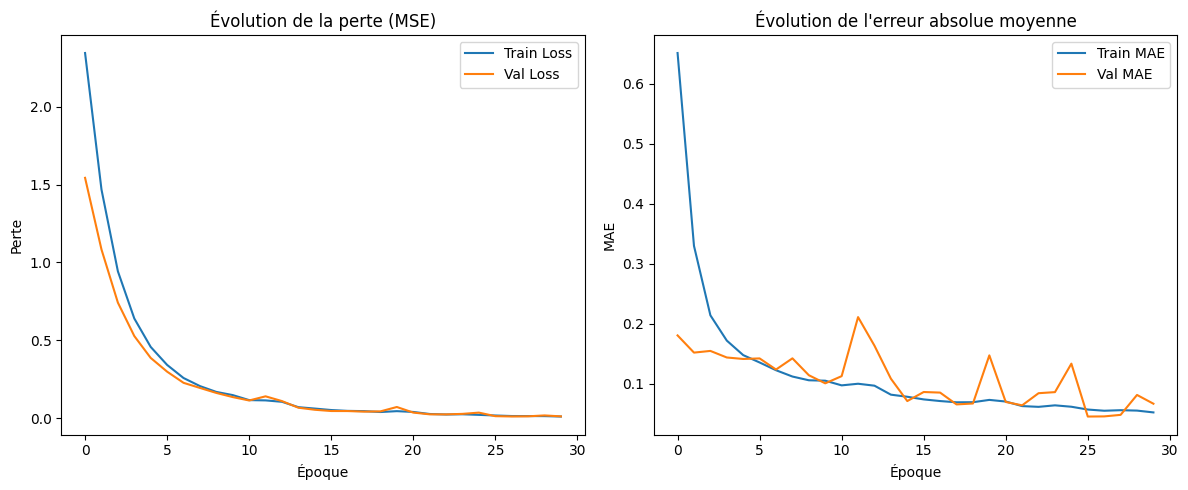

Meilleure époque: 26
Meilleur MAE d'entraînement: 12.92 mois
Meilleur MAE de validation: 10.25 mois

Évaluation du modèle sur l'ensemble de test:
40/40 ━━━━━━━━━━━━━━━━━━━━ 469s 12s/step - loss: 0.0130 - mae: 0.0474
Test Loss (MSE): 0.0127
Test MAE: 0.0455 (normalisé)
Test MAE: 10.38 mois

Visualisation des prédictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


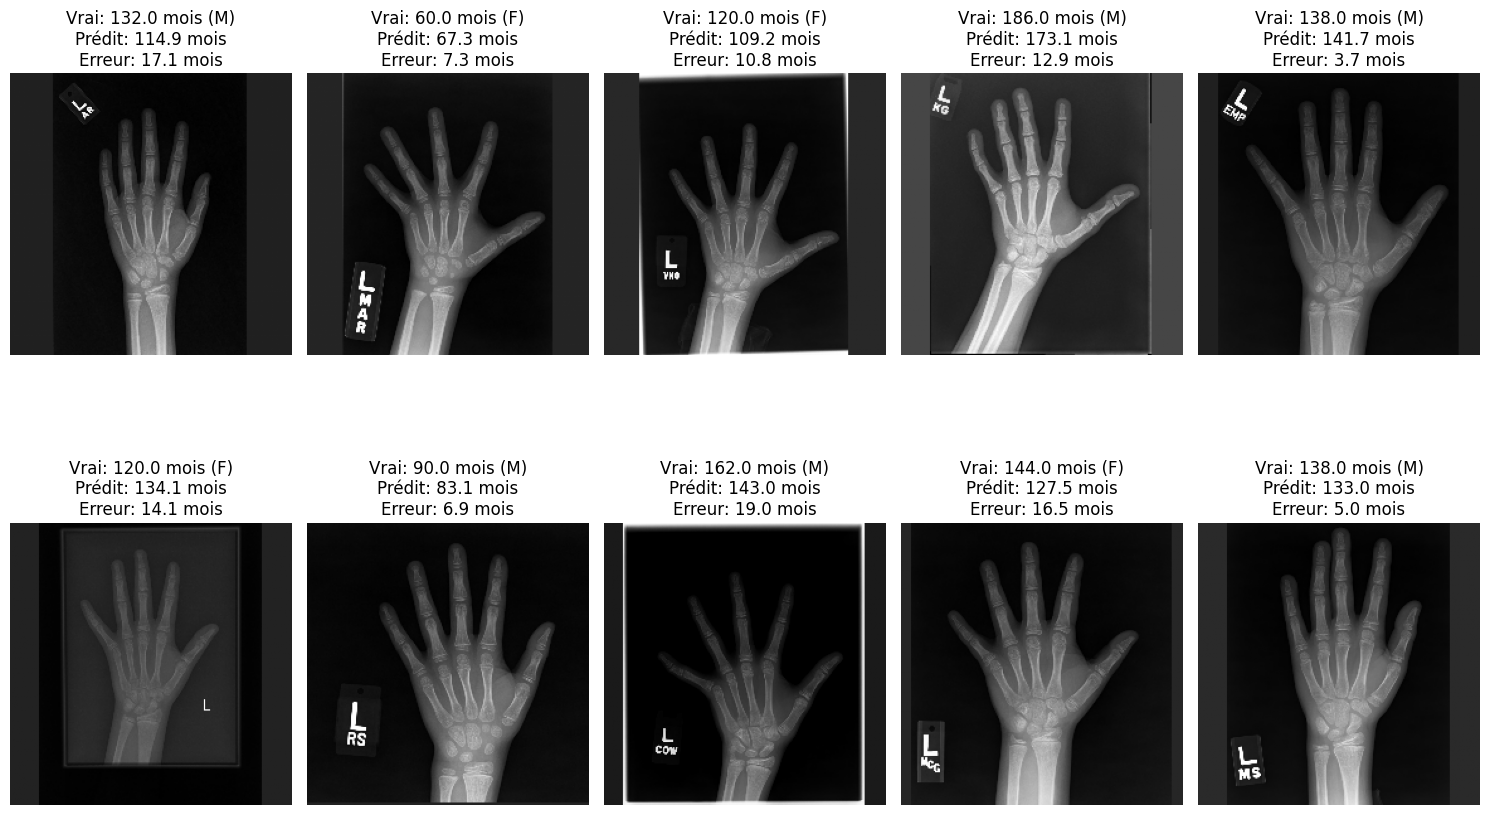

Erreur moyenne: 12.61 mois
Erreur médiane: 10.50 mois
Erreur max: 38.84 mois
Erreur min: 0.81 mois


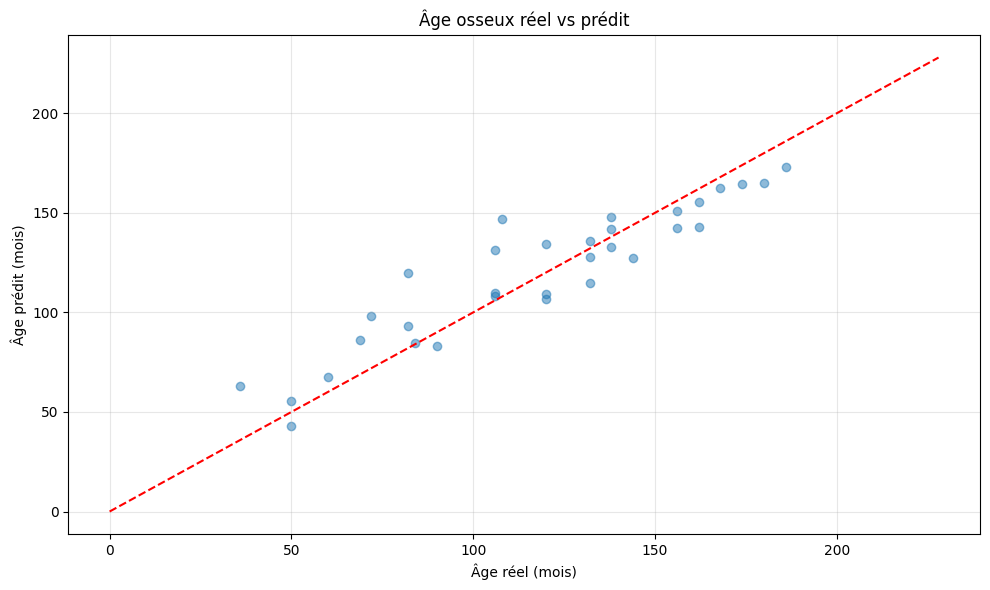


Résumé des performances:
MAE sur l'ensemble de test: 10.38 mois
MSE sur l'ensemble de test: 658.44 mois²


In [ ]:
# Fonctions pour l'évaluation et la visualisation des performances du modèle

# Affiche les courbes d'apprentissage (perte (MSE) et erreur absolue moyenne(MAE))
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Affichage de la courbe de la fonction de perte
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la perte (MSE)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()

    # Affichage de la courbe de l'erreur absolue moyenne (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Évolution de l\'erreur absolue moyenne')
    plt.xlabel('Époque')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Conversion de MAE en mois
    train_mae_months = np.array(history.history['mae']) * 228
    val_mae_months = np.array(history.history['val_mae']) * 228

    # Identification de le meilleur résultat
    best_epoch = np.argmin(history.history['val_mae'])
    print(f"Meilleure époque: {best_epoch + 1}")
    print(f"Meilleur MAE d'entraînement: {train_mae_months[best_epoch]:.2f} mois")
    print(f"Meilleur MAE de validation: {val_mae_months[best_epoch]:.2f} mois")

# Évaluation du modèle sur l'ensemble de test
def evaluate_model(model, test_dataset):
    test_dataset_adapted = adapt_dataset_for_model(test_dataset)
    test_loss, test_mae = model.evaluate(test_dataset_adapted)

    # Conversion de MAE en mois
    test_mae_months = test_mae * 228

    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f} (normalisé)")
    print(f"Test MAE: {test_mae_months:.2f} mois")

    return test_loss, test_mae

def visualize_predictions(model, test_dataset, num_samples=10):
    test_dataset_adapted = adapt_dataset_for_model(test_dataset)

    # Récupérer quelques exemples
    for inputs, true_ages in test_dataset_adapted.take(1):
        
        pred_ages = model.predict(inputs)
        true_ages_months = true_ages.numpy() * 228
        pred_ages_months = pred_ages.flatten() * 228
        errors = np.abs(true_ages_months - pred_ages_months)
        plt.figure(figsize=(15, 10))

        for i in range(min(num_samples, len(true_ages_months))):
            
            plt.subplot(2, 5, i+1)
            plt.imshow(inputs['image_input'][i].numpy().squeeze(), cmap='gray')
            gender = "M" if inputs['gender_input'][i].numpy() == 1 else "F"
            plt.title(f"Vrai: {true_ages_months[i]:.1f} mois ({gender})\n"
                      f"Prédit: {pred_ages_months[i]:.1f} mois\n"
                      f"Erreur: {errors[i]:.1f} mois")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Erreur moyenne: {np.mean(errors):.2f} mois")
        print(f"Erreur médiane: {np.median(errors):.2f} mois")
        print(f"Erreur max: {np.max(errors):.2f} mois")
        print(f"Erreur min: {np.min(errors):.2f} mois")

        plt.figure(figsize=(10, 6))
        plt.scatter(true_ages_months, pred_ages_months, alpha=0.5)
        plt.plot([0, 228], [0, 228], 'r--')  
        plt.title('Âge osseux réel vs prédit')
        plt.xlabel('Âge réel (mois)')
        plt.ylabel('Âge prédit (mois)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Appels aux fonctions précédentes pour l’analyse des résultats
print("Visualisation de l'historique d'entraînement:")
plot_training_history(history)

print("\nÉvaluation du modèle sur l'ensemble de test:")
test_loss, test_mae = evaluate_model(model, test_dataset)

print("\nVisualisation des prédictions:")
visualize_predictions(model, test_dataset, num_samples=10)

# Résumé final des performances
print("\nRésumé des performances:")
print(f"MAE sur l'ensemble de test: {test_mae * 228:.2f} mois")
print(f"MSE sur l'ensemble de test: {test_loss * (228**2):.2f} mois²")